In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]
X_train = X_train.values.reshape(-1, shape, 1)
X_valid = X_valid.values.reshape(-1, shape, 1)
X_test = X_test.values.reshape(-1, shape, 1)

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Conv1D(32, kernel_size=11, strides=3),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=3, strides=2),
    
    layers.Conv1D(64, kernel_size=5, strides=3),
    layers.Conv1D(128, kernel_size=3, strides=2),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2, strides=1),
    
    layers.Flatten(),
    layers.Dense(1024, activation="swish", kernel_regularizer=regularizers.l2(0.002)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002))
])

model.compile(optimizer=optimizers.Adam(0.0005), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('cnn')

Epoch 1/15
2360/2360 [==============================] - 140s 59ms/step - loss: 1.7019 - mae: 0.7180 - mape: 2052.5840 - val_loss: 1.0464 - val_mae: 0.7075 - val_mape: 3684.6616
Epoch 2/15
2360/2360 [==============================] - 140s 59ms/step - loss: 0.9316 - mae: 0.7052 - mape: 1038.2581 - val_loss: 0.9124 - val_mae: 0.7146 - val_mape: 843.6331
Epoch 3/15
2360/2360 [==============================] - 138s 59ms/step - loss: 0.8970 - mae: 0.7050 - mape: 893.2917 - val_loss: 0.9122 - val_mae: 0.7052 - val_mape: 3469.2280
Epoch 4/15
2360/2360 [==============================] - 137s 58ms/step - loss: 0.8939 - mae: 0.7043 - mape: 652.3709 - val_loss: 0.9043 - val_mae: 0.7140 - val_mape: 1055.0486
Epoch 5/15
2360/2360 [==============================] - 137s 58ms/step - loss: 0.8900 - mae: 0.7037 - mape: 736.5716 - val_loss: 0.9006 - val_mae: 0.7104 - val_mape: 974.1143
Epoch 6/15
2360/2360 [==============================] - 136s 58ms/step - loss: 0.8888 - mae: 0.7033 - mape: 591.3121 - v

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=y_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 29s 3ms/step


,predict
count,281840.000000
mean,-0.000599
std,0.001871
min,-0.029120
25%,-0.001394
50%,-0.000280
75%,0.000595
max,0.005538


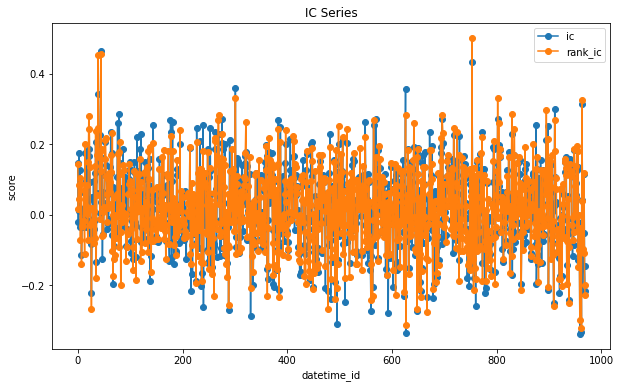

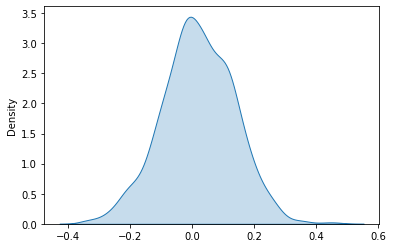

ic= 0.018745178914596837 icir= 0.1611912666079537 rank_ic= 0.016956829687170216 rank_icir= 0.14594338689274922


0.02052386079531732

In [5]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


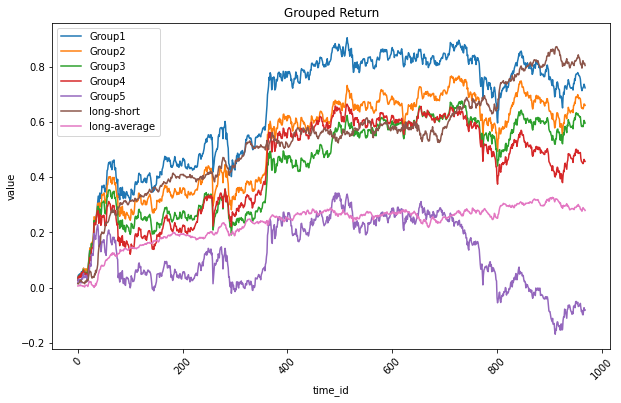

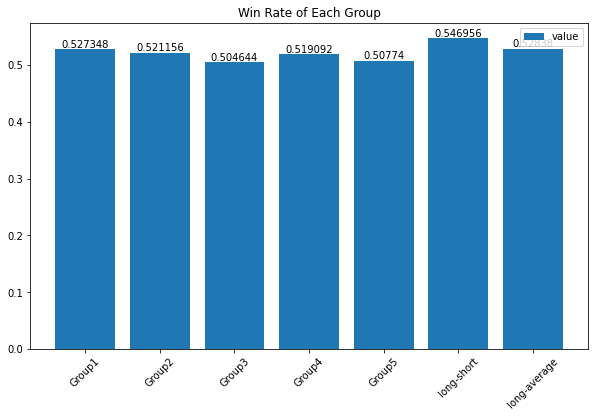

In [6]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)